# Imports

In [1]:
import arviz as az
from scipy.stats import gaussian_kde  # Used for estimating posterior modes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: C:\Users\Achille\.cmdstan
CmdStan version 2.31.0 already installed


True

In [2]:
housing_training_df = pd.read_csv('../data/training_set.csv')
housing_training_df.dropna(inplace = True)

housing_test_df = pd.read_csv('../data/test_set.csv')
housing_test_df.dropna(inplace = True)

# Load models

The MCMC sampled chains corresponding to each model are available via a link on the `gammas.md` file at the root of the repository.

They come in two shapes:
- Directories containing one or several csv files corresponding to the one of several MCMC chains
- `.pkl` representing either `CmdStanPy` or `ArviZ` object

For CSV files:
```{python}
import cmdstanpy
import arviz as az

# Import as stan object
cms_object = cmdstanpy.from_csv("[directory containing only the csv files OR unique csv file]")

# Convert to arviz for analysis
az_object = az.from_cmdstanpy(cms_object)
```

For pkl files (serialized python objects):
```{python}
import cmdstanpy
import arviz as az
import joblib

# Load object using joblib
cms_object = joblib.load("path_to_pkl_file")

# Convert to arviz for analysis
az_object = az.from_cmdstanpy(cms_object)
```

In [3]:
import joblib

In [4]:
simple_glm = cmdstanpy.from_csv("../mcmc_chains/simple_GLM/classic_reg-20230205183557_1.csv")
hierarchical = joblib.load("../mcmc_chains/hierarchical/cms_hierarchical_gammas.pkl")
simple_car = joblib.load("../mcmc_chains/simple_CAR/simple_car_gammas_csm.pkl")
full_car = cmdstanpy.from_csv("../mcmc_chains/full_car/spatial_reg-20230212162704.csv")

22:57:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 126 iterations at max treedepth (12.6%)
	Use function "diagnose()" to see further information.


In [5]:
glm_az = az.from_cmdstanpy(simple_glm)
hier_az = az.from_cmdstanpy(hierarchical)
simple_car_az = az.from_cmdstanpy(simple_car)
full_car_az = az.from_cmdstanpy(full_car)

# Traceplots for assessing convergence

In [29]:
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

reg_param_names = ['avg_room', 'avg_bedr', 'population',
                 'households', 'median_inc', 'housing_me']
oce_param_names = housing_training_df.loc[:,"<1H OCEAN":"NEAR OCEAN":1].columns.to_list()
non_spatial_reg_param_names = ['avg_bedr', 'population', 'households',
                          'median_inc', 'housing_me']

### Simple GLM

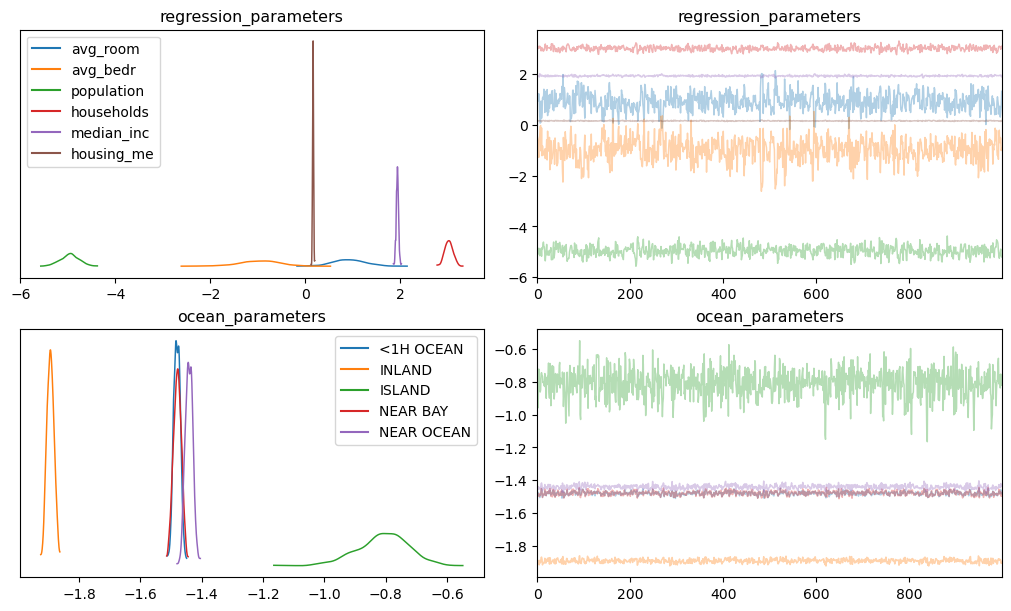

In [34]:
axs = az.plot_trace(glm_az, combined=False, compact=True, var_names=["regression_parameters", "ocean_parameters"], figsize=(10, 6))

reg_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(6)]
ocean_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(5)]

axs[0][0].legend(reg_lines, reg_param_names)
axs[1][0].legend(ocean_lines, oce_param_names)

plt.show()

### Hierarchical

In [8]:
def get_county_indices(housing_df):
  county_names = housing_df.loc[:,'Alameda':'Yuba'].columns
  county_indices = [housing_df.index[housing_df[name]==1] for name in county_names]
  return county_indices, county_names

training_county_indices, county_names = get_county_indices(housing_training_df)
county_names = county_names.to_list()
training_county_masks = []
for county in range(58):
    training_county_masks.append(training_county_indices[county].to_numpy())
    
    
test_county_indices, _ = get_county_indices(housing_test_df)
test_county_masks = []
for county in range(58):
    test_county_masks.append(test_county_indices[county].to_numpy())

In [37]:
def trace_plot_counties(counties):
    county_idx = []
    for county in counties:
        try:
            county_idx.append(county_names.index(county))
        except Exception as e:
            e.raise_with_traceback()
    
    fig, axs = plt.subplots(len(counties) + 1, 2, figsize=(12, (len(counties) + 1) * 3 + 1))
    fig.tight_layout()

    reg_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(6)]
    ocean_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(5)]

    for k, (idx, name) in enumerate(zip(county_idx, counties)):
        az.plot_trace(hier_az, var_names='gamma', coords={'gamma_dim_0': idx}, axes=axs[k:,:])
        axs[k,0].set_title("posteriors, %s county" % name)
        axs[k,1].set_title("traceplot, %s county" % name)

    az.plot_trace(hier_az, var_names='delta', axes=axs[k+1:,:])
    axs[k+1,0].set_title("ocean parameters posteriors")
    axs[k+1,1].set_title("ocean parameters traceplot")

    axs[0][0].legend(reg_lines, reg_param_names)
    axs[k+1][0].legend(ocean_lines, oce_param_names)

    plt.show()

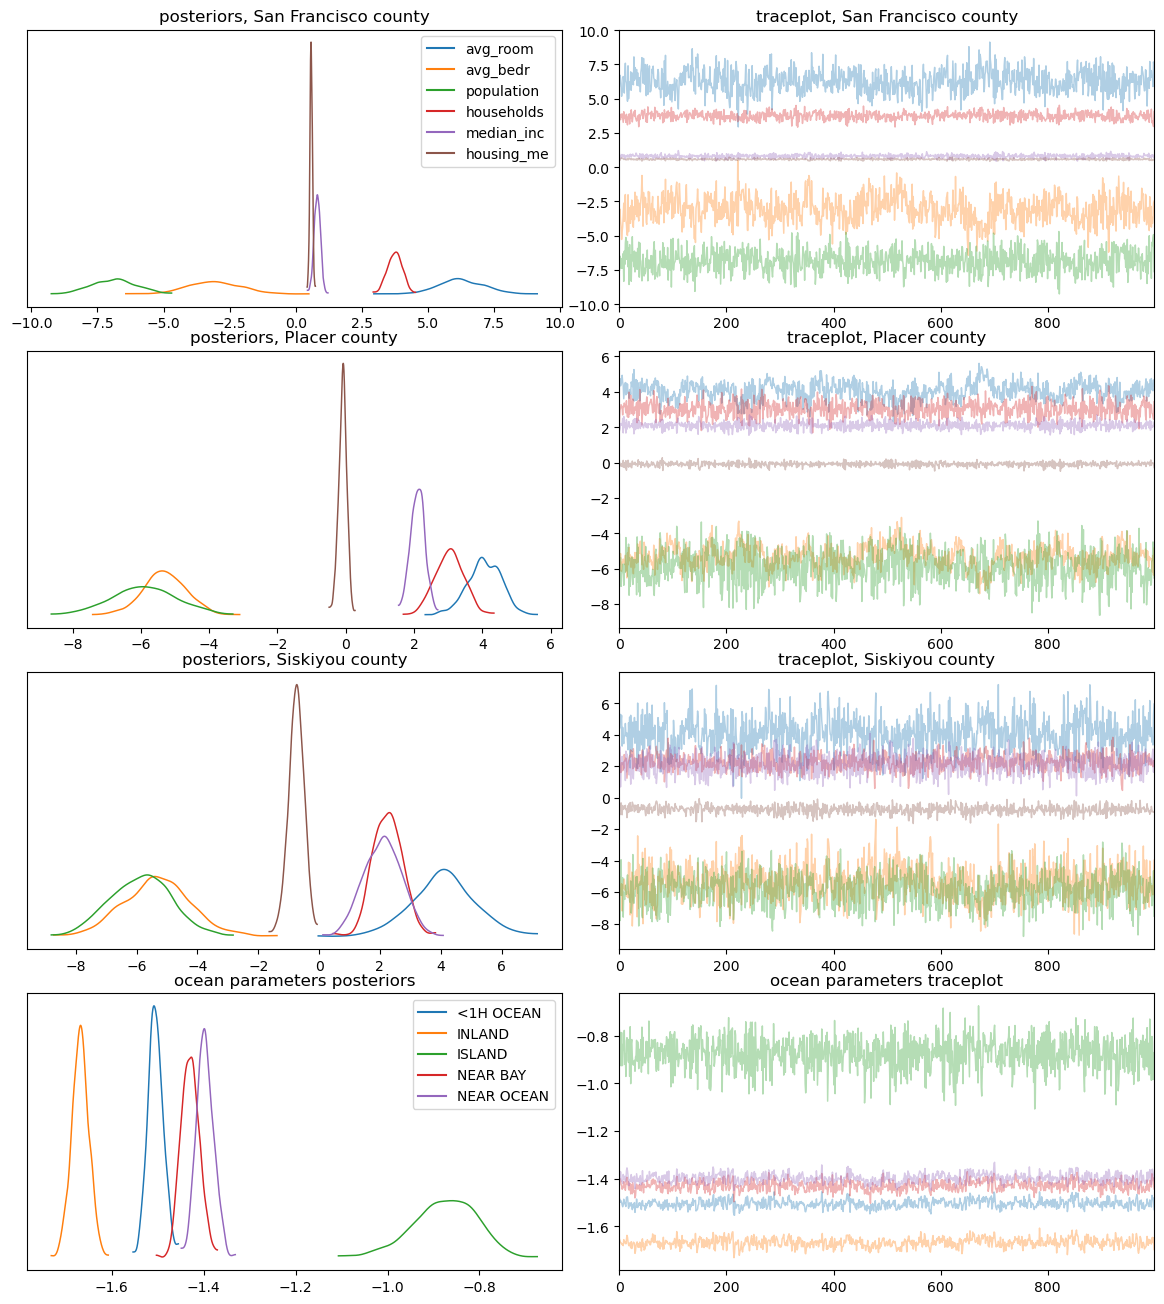

In [38]:
trace_plot_counties(["San Francisco", "Placer", "Siskiyou"])

### Simple CAR

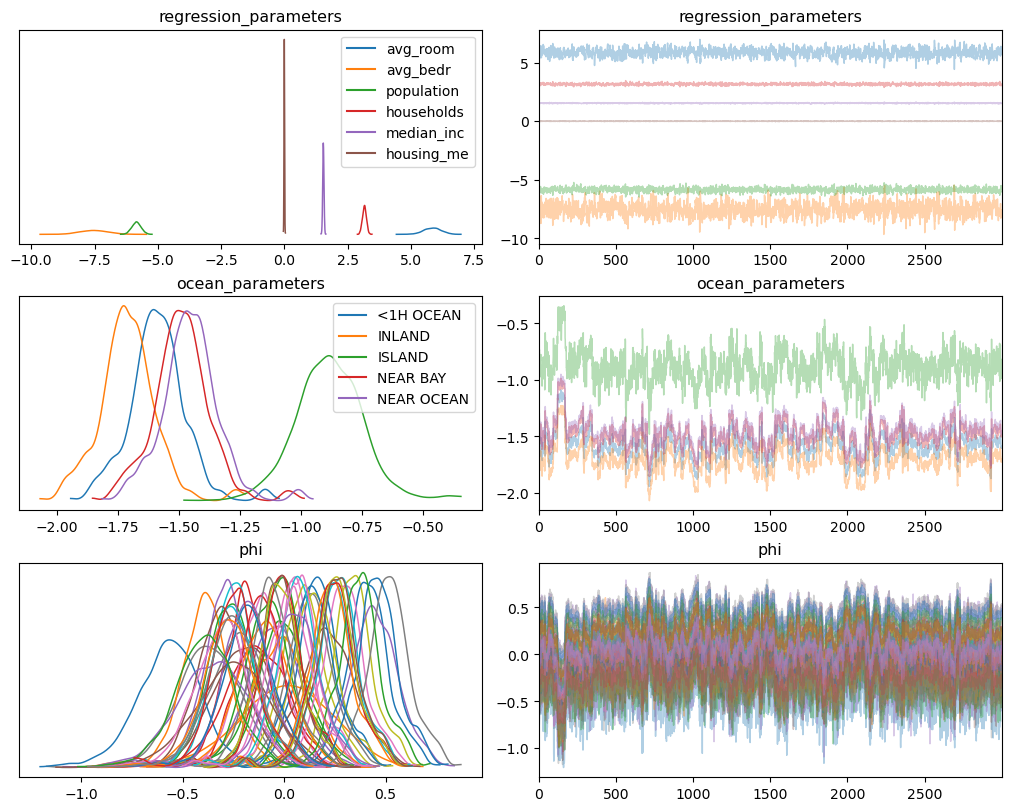

In [25]:
axs = az.plot_trace(simple_car_az, var_names=["regression_parameters", "ocean_parameters", "phi"], compact=True, figsize=(10, 8))

reg_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(6)]
ocean_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(5)]

axs[0][0].legend(reg_lines, reg_param_names)
axs[1][0].legend(ocean_lines, oce_param_names)

plt.show()

### Full CAR

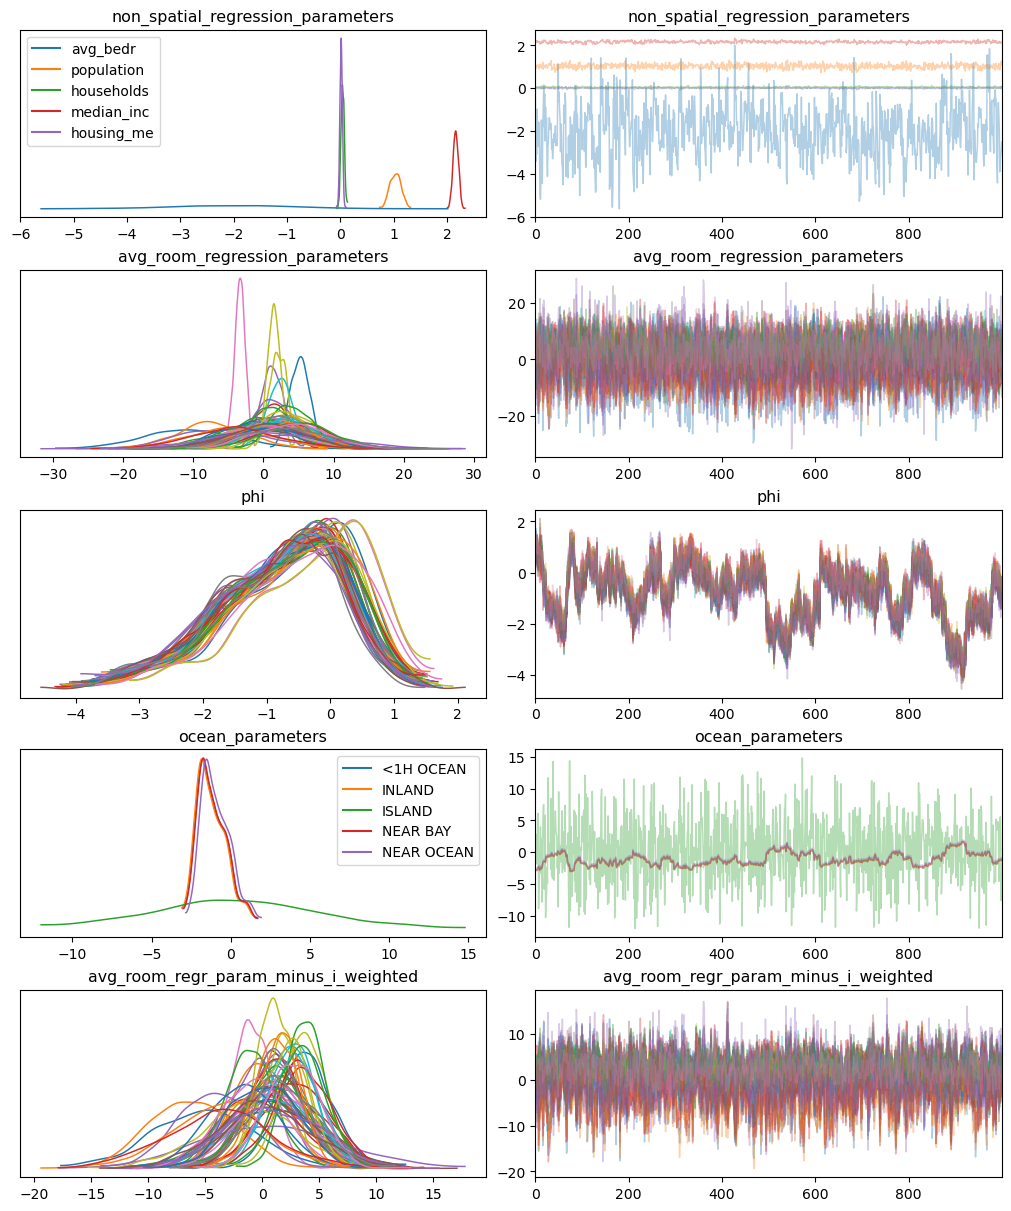

In [31]:
axs = az.plot_trace(
    full_car_az,
    var_names=[
        "non_spatial_regression_parameters",
        "avg_room_regression_parameters",
        "phi",
        "ocean_parameters",
        "avg_room_regr_param_minus_i_weighted"
    ],
compact=True,
figsize=(10,12))

non_spatial_reg_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(5)]
ocean_lines = [plt.Line2D([0], [0], color=default_colors[i]) for i in range(5)]

axs[0][0].legend(non_spatial_reg_lines, non_spatial_reg_param_names)
axs[3][0].legend(ocean_lines, oce_param_names)

plt.show()